# Building a Spam Filter with Naive Bayes

## Introduction

In this project, we are going to classify messages as spam or non-spam with Naive Bayes. 

Our first task is to "teach" the computer how to classify messages. We will use the multinomial Naive Bayes algorithm along with a dataset of 5572 SMS messages that are already classified by humans. 

## Data Exploration

In [2]:
import pandas as pd
import numpy as np

In [3]:
spam_collection = pd.read_csv("SMSSpamCollection", sep = '\t',
                             header = None, names = ['Label', 'SMS'])

print(spam_collection.shape)
spam_collection.head(3)

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [4]:
# Calculate the percentage of spam messages and ham
spam_collection['Label'].value_counts(normalize = True)

ham     0.865937
spam    0.134063
Name: Label, dtype: float64

We can see that the dataset has 5572 rows and 2 columns. 13.41 percentage of messages are spam, while 86.59 percentage is ham.

## Training and Test Set

We are going to keep 80% of our dataset for training, and 20% for testing. Our goal is to create a spam filter that classifies new messages with an accuracy greater than 80%.

In [5]:
# Randomize the dataset
rand_df = spam_collection.sample(frac=1, random_state=1)

# Calculate index of spliting
training_test_index = round(len(rand_df) * 0.8)

# Training/test 
training_set = rand_df[:training_test_index].reset_index(drop = True)
test_set = rand_df[training_test_index:].reset_index(drop = True)

In [8]:
# Calculate the percentage of spam messages and ham
# Training_set
print(training_set['Label'].value_counts(normalize = True))
# Test_set
print(test_set['Label'].value_counts(normalize = True))

ham     0.86541
spam    0.13459
Name: Label, dtype: float64
ham     0.868043
spam    0.131957
Name: Label, dtype: float64


Both in training set and test set, the percentages of spam is nearly 87% and ham are 13%. The percentages are similar to what we have in the full dataset. 

## Data Cleaning

To calculate the probabilities, we'll first need to perform a bit of data cleaning to bring the data in a format that will allow us to extract easily all the information we need. 

Right now, our training and test sets have this format (the messages are fictitious to make the example easier to understand):

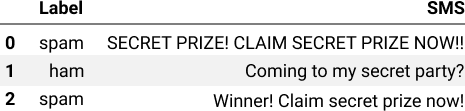

To make the calculations easier, we want bring the data to this format (the table below is a transformation of the table you see above):

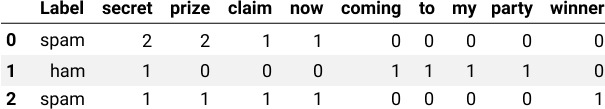

### Letter Case and Punctuation 

First, to remove the punctuation and bring all the words to lower case.

In [10]:
training_set.head(5)

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [11]:
# Remove all punctuations
training_set['SMS'] = training_set['SMS'].str.replace('\W',' ')
# Bring all the words to lower case
training_set['SMS'] = training_set['SMS'].str.lower()

training_set.head(5)

<ipython-input-11-11efa0fe9754>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  training_set['SMS'] = training_set['SMS'].str.replace('\W',' ')


,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


### Creating the Vocabulary

In [12]:
training_set['SMS'] = training_set['SMS'].str.split()

vocabulary = []
for sms in training_set['SMS']:
    for word in sms:
        vocabulary.append(word)
        
vocabulary = list(set(vocabulary))
len(vocabulary)

7783

There are 7783 unique words in all messages of our training set.

### The Final Training Set

In [13]:
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [14]:
# Transfrom to a DataSet
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,tonght,max,gn,deus,staring,100txt,maruti,85,fyi,cheese,...,foley,oooh,there,invitation,registration,fro,pixels,goodnoon,predicting,sup
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [15]:
# Concentrate two datasets
training_set_new = pd.concat([training_set, word_counts], axis = 1)
training_set_new.head(5)

,Label,SMS,tonght,max,gn,deus,staring,100txt,maruti,85,...,foley,oooh,there,invitation,registration,fro,pixels,goodnoon,predicting,sup
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## Calculating Constants First

Now, we can begin creating the spam filter.

In [20]:
# Calculate P(Spam) and P(Ham)
spam_message = training_set_new[training_set_new['Label'] == 'spam']
ham_message = training_set_new[training_set_new['Label'] == 'ham']

p_spam = len(spam_message) / len(training_set_new)
p_ham = len(ham_message) / len(training_set_new)

print(p_spam, p_ham)

0.13458950201884254 0.8654104979811574


In [22]:
# Calculate N_Spam, N_Ham, N_Vocabulary
## N_spam
n_words_per_spam_message = spam_message['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()

## N_ham
n_words_per_ham_message = ham_message['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()

## N_vocabulary
n_vocabulary = len(vocabulary)

##Laplace smoothing
alpha = 1

print(n_spam, n_ham, n_vocabulary)

15190 57237 7783


## Calculating Parameters

In [27]:
# Initialize parameters
parameters_spam = {unique_word: 0 for unique_word in vocabulary}
parameters_ham = {unique_word: 0 for unique_word in vocabulary}

In [29]:
# Calculate parameters
for word in vocabulary:
    # for spam messages
    n_word_given_spam = spam_message[word].sum()
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha * n_vocabulary)
    parameters_spam[word] = p_word_given_spam
    
    # for ham messages
    n_word_given_ham = ham_message[word].sum()
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha * n_vocabulary)
    parameters_ham[word] = p_word_given_ham

## Classifying a new message

In [32]:
import re

def classify(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
        if word in parameter_ham:
            p_ham_given_message *= parameters_ham[word]
           
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [33]:
# Test 1 
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam


In [34]:
# Test 2
classify("Sounds good, Tom, then see u there")

P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21
Label: Ham


## Measuring the Spam Filter's Accuracy

We'll now try to determine how well the spam filter does on our test set of 1,114 messages. The algorithm will output a classification label for every message in our test set, which we'll be able to compare with the actual label (given by a human).

In [35]:
def classify_test_set(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]

        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

Now that we have a function that returns labels instead of printing them, we can use it to create a new column in our test set.


In [36]:
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


### Measure the accuracy of the spam filter

In [37]:
correct = 0
total = test_set.shape[0]

for row in test_set.iterrows():
    row = row[1]
    if row['Label'] == row['predicted']:
        correct += 1 

print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct/total)

Correct: 1100
Incorrect: 14
Accuracy: 0.9874326750448833


The accauracy is close to 98.74%, which is really good. 

## Conclusion

In this project, we managed to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm. **The filter had an accuracy of 98.74% on the test set, which is an excellent result.** We initially aimed for an accuracy of over 80%, but we managed to do way better than that.

